In [1]:
import numpy as np
import pandas as pd
import random
from os.path import join
import os
import pickle
from glob import glob
import json
import sys

from sklearn.metrics.pairwise import cosine_similarity

In [51]:
DATA_DIR = '../data/'
df_scores_vectors = glob(DATA_DIR + 'scores_modifications*')
df_scores = pd.DataFrame()
for df_score in df_scores_vectors:
    df_score_l = pd.read_csv(df_score)
    df_scores = pd.concat([df_scores, df_score_l], axis=0)

df_scores = df_scores.sort_values('Final Score', ascending=False).reset_index()
df_scores.loc[df_scores['Variable'] == 'V1', 'Feature'] = 'V1'
df_scores.loc[df_scores['Variable'] == 'S1', 'Feature'] = 'S1'
df_scores['Method General'] = df_scores['Method'].str.split('_').apply(lambda x: x[0].replace('False', '').replace('True', ''))

separation_vectors = glob(DATA_DIR + '*_separation_vector*.csv')
df_sep_vecs = pd.DataFrame()
for df_sep_vec in separation_vectors:
    if 'modifications' not in df_sep_vec:
        df_sep_vec_l = pd.read_csv(df_sep_vec)
        df_sep_vecs = pd.concat([df_sep_vecs, df_sep_vec_l], axis=0)
df_sep_vecs.loc[df_sep_vecs['Variable'] == 'V1', 'Feature'] = 'V1'
df_sep_vecs.loc[df_sep_vecs['Variable'] == 'S1', 'Feature'] = 'S1'

df_scores = df_scores.merge(df_sep_vecs, left_on=['Feature','Variable','Method'], right_on=['Feature','Variable','Method'], how='left')
df_scores['Separation Vector (np)'] = [np.array([float(x.strip('[] ')) for x in row['Separation Vector'].replace('\n', ' ').split(' ') if x.strip('[] ') != '']) for i, row in df_scores.iterrows()]
print(df_scores[['Feature', 'Variable', 'Method', 'Final Score']].sample(10), df_scores.shape)


    Feature Variable                             Method  Final Score
158      V1       V1    InterfaceGAN_LR_0.01_8_V1_False        0.201
166   Brown    Color    StyleSpaceFalse_5_8_Color_False        0.189
173      BW    Color    StyleSpaceFalse_1_8_Color_False        0.162
189   Green    Color    StyleSpaceFalse_5_8_Color_False        0.108
192   Green    Color   StyleSpaceFalse_20_8_Color_False        0.081
99    Green    Color     ShapleyVec_True_0.5_8_Color_LR        0.427
105    Cyan    Color     StyleSpaceTrue_5_8_Color_False        0.387
67       S1       S1        InterfaceGAN_LR_1_8_S1_True        0.615
95     Cyan    Color     ShapleyVec_True_0.5_8_Color_LR        0.434
143   Green    Color  InterfaceGAN_LR_0.01_8_Color_True        0.243 (220, 31)


/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78207/1485801114.py:6: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



<img src="../data/Linear_RGB_color_wheel.png" width="300" height="300" style="align-text:center">

Obtaining the general similarities between vectors to see which colors are represented to be most alike and which not

In [55]:
df_scores = df_scores.groupby(['Method General', 'Feature']).first()
df_scores = df_scores.reset_index()
similarities = {}
colors = df_scores['Feature'].unique()
for method, group in df_scores.groupby('Method General'):
    print('Assessing similarity among vectors computed with:', method)
    for color1 in colors:
        if color1 not in similarities.keys():
            similarities[color1] = {}
        for color2 in colors:
            if color2 not in similarities[color1].keys():
                similarities[color1][color2] = []
            
            if color1 != color2:
                if len(list(group.loc[group['Feature']==color1, 'Separation Vector (np)'])
                       ) > 0 and len(list(group.loc[group['Feature']==color2, 'Separation Vector (np)'])) > 0:
                    similarity = cosine_similarity(list(group.loc[group['Feature']==color1, 'Separation Vector (np)'])[0].reshape(1, -1),
                                                list(group.loc[group['Feature']==color2, 'Separation Vector (np)'])[0].reshape(1, -1)
                                                )
                    similarities[color1][color2].append(similarity[0][0])
                    print('Similarity between', color1, 'and', color2, 'is', np.round(similarity[0][0],3))

Assessing similarity among vectors computed with: InterfaceGAN
Similarity between BW and Blue is -0.475
Similarity between BW and Brown is 0.425
Similarity between BW and Cyan is -0.417
Similarity between BW and Green is -0.301
Similarity between BW and Magenta is -0.304
Similarity between BW and Red is -0.072
Similarity between BW and S1 is -0.623
Similarity between BW and V1 is -0.324
Similarity between BW and Yellow is 0.334
Similarity between Blue and BW is -0.475
Similarity between Blue and Brown is -0.513
Similarity between Blue and Cyan is 0.472
Similarity between Blue and Green is 0.129
Similarity between Blue and Magenta is 0.049
Similarity between Blue and Red is -0.38
Similarity between Blue and S1 is 0.052
Similarity between Blue and V1 is -0.044
Similarity between Blue and Yellow is -0.421
Similarity between Brown and BW is 0.425
Similarity between Brown and Blue is -0.513
Similarity between Brown and Cyan is -0.57
Similarity between Brown and Green is -0.401
Similarity be

In [17]:
import plotly.graph_objects as go
import numpy as np

colors = df_scores['Feature'].unique()

# Assuming 'similarities' is a dictionary with your calculated similarities
# Calculate the average similarities
for color1 in similarities:
    for color2 in similarities[color1]:
        similarities[color1][color2] = np.round(np.mean(similarities[color1][color2]),2)

# Prepare data for Sankey diagram
source = []
target = []
value = []
# colors_out = [col+'_out' for col in colors]
color_index = {color: i for i, color in enumerate(list(colors))}
print(color_index)
for color1 in similarities:
    for color2 in similarities[color1]:
        if color1 != color2:
            source.append(color_index[color1])
            target.append(color_index[color2])
            value.append(abs(similarities[color1][color2]))  # Use absolute values

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=list(colors)
    ),
    link=dict(
      source=source,
      target=target,
      value=value
    ))])

fig.update_layout(title_text="Average Similarities Among Colors", font_size=10)
fig.show()


{'BW': 0, 'Blue': 1, 'Brown': 2, 'Cyan': 3, 'Green': 4, 'Magenta': 5, 'Red': 6, 'S1': 7, 'V1': 8, 'Yellow': 9}


In [5]:
for c1 in similarities.keys():
    for c2 in similarities[c1].keys():
        if len(similarities[c1][c2]) > 0:
            print('Average similarity across methods', c1, c2, 'is', np.round(np.mean(similarities[c1][c2]), 3),
                  'with std', np.round(np.std(similarities[c1][c2]), 3))

Average similarity across methods BW Blue is -0.184 with std 0.208
Average similarity across methods BW Brown is 0.103 with std 0.232
Average similarity across methods BW Cyan is -0.231 with std 0.173
Average similarity across methods BW Green is -0.281 with std 0.042
Average similarity across methods BW Magenta is -0.004 with std 0.254
Average similarity across methods BW Red is -0.068 with std 0.054
Average similarity across methods BW S1 is -0.623 with std 0.0
Average similarity across methods BW V1 is -0.324 with std 0.0
Average similarity across methods BW Yellow is 0.014 with std 0.235
Average similarity across methods Blue BW is -0.184 with std 0.208
Average similarity across methods Blue Brown is -0.182 with std 0.234
Average similarity across methods Blue Cyan is 0.376 with std 0.155
Average similarity across methods Blue Green is 0.204 with std 0.14
Average similarity across methods Blue Magenta is -0.037 with std 0.079
Average similarity across methods Blue Red is -0.145 wit

<img src="../data/color_systems.png" width="400" height="200">

Now trying out different vector algebras to see which properties from the subtractive and additive schemes hold

In [22]:
df_scores_interface = df_scores[df_scores['Method General'] == 'InterfaceGAN']

In [23]:
print(df_scores_interface.shape)
# df_scores_interface = df_scores_interface[~df_scores_interface['Feature'].isin(['S1', 'V1', 'BW', 'Brown'])].reset_index()

df_scores_interface.head(1)

(10, 31)


,Method General,Feature,index,Method,Variable,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,...,Score lambda 14,Score lambda 15,Final Score,Space,Subfolder,Performance,Classes,Bins,Separation Vector,Separation Vector (np)
0,InterfaceGAN,BW,33,InterfaceGAN_LR_1_8_Color_True,Color,1.0,7.0,0.661,0.108,0.189,...,0.892,0.919,0.73,w,interfaceGAN/color/,0.65,"BW, Brown, Yellow, Cyan, Blue, Green, Red, Mag...","[0, 35, 70, 150, 200, 260, 345, 360]",[-2.66842892e-02 -8.21213069e-03 -3.07416816e-...,"[-0.0266842892, -0.00821213069, -0.00307416816..."


In [24]:
color2vector = {k:v for k,v in zip(df_scores_interface['Feature'],df_scores_interface['Separation Vector (np)'])}

In [25]:
# Function to normalize a vector
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

# Sum and subtract pairwise and normalize
resultant_vectors = [(normalize(a*v1 + b*v2), k1 + '+' + k2 + ' a ' + str(a) + ' b ' + str(b)
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() for a in range(1,5) 
                     for b in range(1,5) if k1 != k2 and k1 not in ['S1', 'V1', 'BW', 'Brown'] and k2 not in ['S1', 'V1', 'BW', 'Brown']]


resultant_vectors += [(normalize(a*v1 - b*v2), k1 + '-' + k2 + ' a ' + str(a) + ' b ' + str(b)
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() for a in range(1,5) 
                     for b in range(1,5) if k1 != k2 and k1 not in ['S1', 'V1', 'BW', 'Brown'] and k2 not in ['S1', 'V1', 'BW', 'Brown']]

# Find the most similar vector
for rv in resultant_vectors:
    most_similar = None
    highest_similarity = -1
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if np.abs(similarity) > highest_similarity:
                if ov[0] not in rv[1]:
                    most_similar = ov[0]
                    highest_similarity = similarity
    if highest_similarity > 0.2:
        print("Most Similar Vector:", most_similar, 'to', rv[1], 'with similarity', highest_similarity)


Most Similar Vector: Cyan to Blue+Green a 2 b 1 with similarity 0.21312492917183803
Most Similar Vector: Cyan to Blue+Green a 3 b 1 with similarity 0.20664141485495902
Most Similar Vector: Cyan to Blue+Green a 4 b 1 with similarity 0.20220352549641868
Most Similar Vector: Cyan to Blue+Green a 4 b 2 with similarity 0.21312492917183803
Most Similar Vector: Cyan to Green+Blue a 1 b 2 with similarity 0.21312492917183803
Most Similar Vector: Cyan to Green+Blue a 1 b 3 with similarity 0.20664141485495902
Most Similar Vector: Cyan to Green+Blue a 1 b 4 with similarity 0.20220352549641868
Most Similar Vector: Cyan to Green+Blue a 2 b 4 with similarity 0.21312492917183803
Most Similar Vector: Red to Blue-Cyan a 1 b 3 with similarity 0.20480038260271805
Most Similar Vector: Red to Blue-Cyan a 1 b 4 with similarity 0.21721847900932634
Most Similar Vector: Cyan to Blue-Red a 1 b 1 with similarity 0.2404898538754201
Most Similar Vector: Cyan to Blue-Red a 1 b 2 with similarity 0.23995043847331815
M

In [26]:
additive_colors = [(normalize(v1 + v2), k1 + '+' + k2
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() 
                   if k1 != k2 and k1 in ['Red', 'Green', 'Blue'] and k2 in ['Red', 'Green', 'Blue']]


subtractive_colors = [(normalize(v1 - v2), k1 + '-' + k2 
                      ) for k1, v1 in color2vector.items() for k2, v2 in color2vector.items() 
                      if k1 != k2 and k1 in ['Cyan', 'Magenta', 'Yellow'] and k2 in ['Cyan', 'Magenta', 'Yellow']]

# Find the most similar vector
for rv in additive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                print("Vector:", ov[0], 'is similar to', rv[1], 'with similarity', similarity)


Vector: Cyan is similar to Blue+Green with similarity 0.21869010924603732
Vector: Magenta is similar to Blue+Green with similarity -0.048473747849907975
Vector: Red is similar to Blue+Green with similarity -0.22979357033822043
Vector: Yellow is similar to Blue+Green with similarity -0.07932597459401154
Vector: Cyan is similar to Blue+Red with similarity -0.038478310647898625
Vector: Green is similar to Blue+Red with similarity -0.08801430672235136
Vector: Magenta is similar to Blue+Red with similarity 0.10140169228445736
Vector: Yellow is similar to Blue+Red with similarity -0.15538380610124455
Vector: Cyan is similar to Green+Blue with similarity 0.21869010924603732
Vector: Magenta is similar to Green+Blue with similarity -0.048473747849907975
Vector: Red is similar to Green+Blue with similarity -0.22979357033822043
Vector: Yellow is similar to Green+Blue with similarity -0.07932597459401154
Vector: Blue is similar to Green+Red with similarity -0.12366297522396463
Vector: Cyan is simi

In [28]:
import plotly.graph_objects as go
import numpy as np

# Assuming color2vector is your dictionary of colors to vectors
# and you've computed additive_colors and subtractive_colors as given

# Calculate similarities and prepare data for Sankey diagram
source = []
target = []
value = []
labels = []

# Additive colors
for rv in additive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                # Add to Sankey data
                if rv[1] not in labels:
                    labels.append(rv[1])
                if ov[0] not in labels:
                    labels.append(ov[0])

                source.append(labels.index(rv[1]))
                target.append(labels.index(ov[0]))
                value.append(similarity)

# Assuming subtractive_colors follows the same structure
for rv in subtractive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                # Add to Sankey data
                if rv[1] not in labels:
                    labels.append(rv[1])
                if ov[0] not in labels:
                    labels.append(ov[0])

                source.append(labels.index(rv[1]))
                target.append(labels.index(ov[0]))
                value.append(similarity)
    # Similar logic as above

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=value
    ))])

fig.update_layout(title_text="Similarities between Additive and Subtractive Colors", font_size=10)
fig.show()


In [41]:
# Find the most similar vector
for rv in subtractive_colors:
    for ov in color2vector.items():
        if ov[0] not in ['S1', 'V1', 'BW', 'Brown']:
            similarity = np.dot(rv[0], ov[1])
            if ov[0] not in rv[1]:
                print("Vector:", ov[0], 'is similar to', rv[1], 'with similarity', similarity)


Vector: Blue is similar to Cyan-Magenta with similarity 0.12587683731204344
Vector: Green is similar to Cyan-Magenta with similarity 0.14263542796163564
Vector: Red is similar to Cyan-Magenta with similarity -0.2466931894800054
Vector: Yellow is similar to Cyan-Magenta with similarity 0.028695031451628116
Vector: Blue is similar to Cyan-Yellow with similarity 0.23007314367393233
Vector: Green is similar to Cyan-Yellow with similarity 0.06804331696217854
Vector: Magenta is similar to Cyan-Yellow with similarity 0.054292668391245386
Vector: Red is similar to Cyan-Yellow with similarity -0.1295734258700925
Vector: Blue is similar to Magenta-Cyan with similarity -0.12587683731204344
Vector: Green is similar to Magenta-Cyan with similarity -0.14263542796163564
Vector: Red is similar to Magenta-Cyan with similarity 0.2466931894800054
Vector: Yellow is similar to Magenta-Cyan with similarity -0.028695031451628116
Vector: Blue is similar to Magenta-Yellow with similarity 0.10633974947524305
Ve

Similarity across channels

In [52]:
df_scores_shapley = df_scores[df_scores['Method General'] == 'ShapleyVec'][df_scores['Method'].str.contains('0.25')]
print(df_scores_shapley.shape)
df_scores_shapley.head(1)

(16, 31)


/var/folders/s_/h4qqxs0s7mg2fw0j2hmf3jgh0000gn/T/ipykernel_78207/2462186999.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,index,Method,Variable,Feature,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,Score lambda 3,...,Score lambda 15,Final Score,Method General,Space,Subfolder,Performance,Classes,Bins,Separation Vector,Separation Vector (np)
1,5,ShapleyVec_True_0.25_8_Color_LR,Color,Yellow,1.0,15.0,0.884,0.746,0.775,0.771,...,0.93,0.967,ShapleyVec,w,ShapleyVec/color/,NaN,"BW, Brown, Yellow, Cyan, Blue, Green, Red, Mag...","[0, 35, 70, 150, 200, 260, 345, 360]",[ 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2339, 0..."


In [53]:
channels = {}
for color, vecs in zip(df_scores_shapley['Feature'], df_scores_shapley['Separation Vector (np)']):
    channels[color] = np.where(vecs != 0)
    print('Color', color, 'requires', len(channels[color][0]), 'channels to represent it')

colors = df_scores_shapley['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            print('Color', color1, 'and color', color2, 'intersect by', len(inters), 'channels, out of the max possible channels', 
                  min(len(channels[color2][0]), len(channels[color1][0])))

Color Yellow requires 28 channels to represent it
Color Brown requires 27 channels to represent it
Color Red requires 28 channels to represent it
Color Yellow requires 28 channels to represent it
Color Brown requires 27 channels to represent it
Color Blue requires 30 channels to represent it
Color BW requires 28 channels to represent it
Color BW requires 28 channels to represent it
Color Red requires 28 channels to represent it
Color Blue requires 30 channels to represent it
Color Cyan requires 27 channels to represent it
Color Magenta requires 25 channels to represent it
Color Green requires 21 channels to represent it
Color Cyan requires 27 channels to represent it
Color Magenta requires 25 channels to represent it
Color Green requires 21 channels to represent it
Color Yellow and color Brown intersect by 11 channels, out of the max possible channels 27
Color Yellow and color Red intersect by 5 channels, out of the max possible channels 28
Color Yellow and color Blue intersect by 8 ch

[[ 1.21446168  1.49982457]
 [-0.25555381 -0.08115598]
 [-0.12775599  0.83630174]
 [ 1.15352737  0.81286622]
 [ 0.51604173  1.20014093]
 [ 0.54556035 -0.49129744]
 [ 0.50814294  0.43864308]
 [-0.12973743 -0.91167993]]


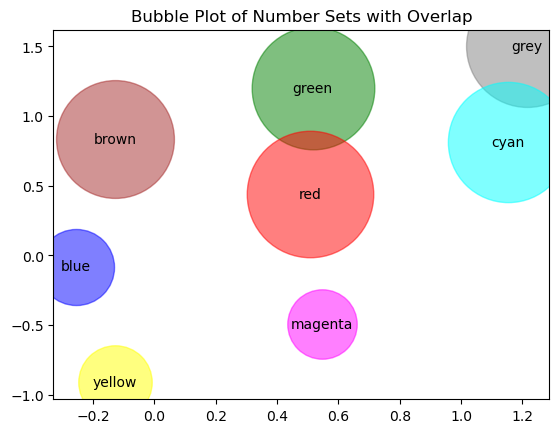

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize


# Example data: 8 sets of numbers
sets = [set(list(chan[0])) for chan in list(channels.values())]
names = [col.lower() if col != 'BW' else 'grey' for col in list(channels.keys())]


# Calculate desired overlaps
desired_overlaps = np.zeros((len(sets), len(sets)))
for i, set1 in enumerate(sets):
    for j, set2 in enumerate(sets):
        if i != j:
            overlap = len(set1.intersection(set2)) / len(set1.union(set2))
            desired_overlaps[i, j] = overlap


# Function to minimize: difference between actual and desired overlaps
def overlap_error(positions):
    positions = positions.reshape((len(sets), 2))
    error = 0
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            dx, dy = positions[i] - positions[j]
            distance = np.sqrt(dx**2 + dy**2)
            actual_overlap = max(0, 1 - distance)  # Simplified overlap calculation
            error += (actual_overlap - desired_overlaps[i, j])**2
    return error

# Initial positions
initial_positions = np.random.rand(len(sets), 2).flatten()

# Minimize the error function
optimized = minimize(overlap_error, initial_positions, method='BFGS')
optimized_positions = optimized.x.reshape((len(sets), 2))

print(optimized_positions)
fig, ax = plt.subplots()
for i, s in enumerate(sets):
    ax.scatter(optimized_positions[i, 0], optimized_positions[i, 1], s=100 * len(s), alpha=0.5, color=names[i])
    ax.text(optimized_positions[i, 0], optimized_positions[i, 1], f"{names[i]}", ha='center', va='center', color='black')

plt.title("Bubble Plot of Number Sets with Overlap")
plt.show()


In [99]:
colors = df_scores_shapley['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            for color3 in colors:
                if color3 != color2 and color3 != color1:
                    inters = np.intersect1d(channels[color3], inters)
                    for color4 in colors:
                        if color4 != color2 and color4 != color1 and color4 != color3:
                            inters = np.intersect1d(channels[color4], inters)
                            if len(inters) > 0:
                                print('Color', color1, ', color', color2, ', color', color3, 'and color', color4, 'intersect by', len(inters), 'node(s)', inters)

Color BW , color Blue , color Brown and color Cyan intersect by 2 node(s) [253 463]
Color BW , color Brown , color Blue and color Cyan intersect by 2 node(s) [253 463]
Color BW , color Cyan , color Blue and color Brown intersect by 2 node(s) [253 463]
Color BW , color Magenta , color Blue and color Brown intersect by 1 node(s) [253]
Color BW , color Magenta , color Blue and color Cyan intersect by 1 node(s) [253]
Color BW , color Red , color Blue and color Brown intersect by 2 node(s) [253 361]
Color BW , color Red , color Blue and color Cyan intersect by 1 node(s) [253]
Color BW , color Yellow , color Blue and color Brown intersect by 3 node(s) [253 451 463]
Color BW , color Yellow , color Blue and color Cyan intersect by 2 node(s) [253 463]
Color Blue , color BW , color Brown and color Cyan intersect by 2 node(s) [253 463]
Color Blue , color Brown , color BW and color Cyan intersect by 2 node(s) [253 463]
Color Blue , color Cyan , color BW and color Brown intersect by 2 node(s) [253 

Now we do the same for stylespace

In [56]:
df_scores_stylespace = df_scores[df_scores['Method General'] == 'StyleSpace']
print(df_scores_stylespace.shape)
df_scores_stylespace.head(1)

(8, 31)


,Method General,Feature,index,Method,Variable,Broad,Optimal lambda,Total Score,Score lambda 1,Score lambda 2,...,Score lambda 14,Score lambda 15,Final Score,Space,Subfolder,Performance,Classes,Bins,Separation Vector,Separation Vector (np)
18,StyleSpace,BW,80,StyleSpaceTrue_1_8_Color_False,Color,0.0,15.0,0.178,0.054,0.081,...,0.378,0.405,0.405,w,StyleSpace/color/,NaN,"BW, Brown, Yellow, Cyan, Blue, Green, Red, Mag...","[0, 35, 70, 150, 200, 260, 345, 360]",[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [57]:
channels = {}
for color, vecs in zip(df_scores_stylespace['Feature'], df_scores_stylespace['Separation Vector (np)']):
    channels[color] = np.where(vecs != 0)
    print('Color', color, 'requires', len(channels[color][0]), 'channels to represent it')

colors = df_scores_stylespace['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            print('Color', color1, 'and color', color2, 'intersect by', len(inters), inters, 'channels, out of the max possible channels', 
                  min(len(channels[color2][0]), len(channels[color1][0])))

Color BW requires 1 channels to represent it
Color Blue requires 5 channels to represent it
Color Brown requires 5 channels to represent it
Color Cyan requires 20 channels to represent it
Color Green requires 20 channels to represent it
Color Magenta requires 10 channels to represent it
Color Red requires 20 channels to represent it
Color Yellow requires 20 channels to represent it
Color BW and color Blue intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Brown intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Cyan intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Green intersect by 1 [119] channels, out of the max possible channels 1
Color BW and color Magenta intersect by 1 [119] channels, out of the max possible channels 1
Color BW and color Red intersect by 0 [] channels, out of the max possible channels 1
Color BW and color Yellow intersect by 1 [119] channels, out of the max possible ch

In [58]:
colors = df_scores_stylespace['Feature'].unique()
for color1 in colors:
    for color2 in colors:
        if color1 != color2:
            inters = np.intersect1d(channels[color1], channels[color2])
            for color3 in colors:
                if color3 != color2 and color3 != color1:
                    inters = np.intersect1d(channels[color3], inters)
                    #for color4 in colors:
                    #    if color4 != color2 and color4 != color1 and color4 != color3:
                    #        inters = np.intersect1d(channels[color4], inters)
                    if len(inters) > 0:
                        print('Color', color1, ', color', color2, ', color', color3, 'intersect by', len(inters), 'node(s)', inters)

Color Green , color Magenta , color BW intersect by 1 node(s) [119]
Color Green , color Yellow , color BW intersect by 1 node(s) [119]
Color Magenta , color Green , color BW intersect by 1 node(s) [119]
Color Magenta , color Yellow , color BW intersect by 1 node(s) [119]
Color Yellow , color Green , color BW intersect by 1 node(s) [119]
Color Yellow , color Magenta , color BW intersect by 1 node(s) [119]
